In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
GRID_SIZE = 5
START_STATE = (0, 0)
FOOD_STATE = (4, 4)
ACTIONS = [(0, -1), (0, 1), (-1, 0), (1, 0)]
FORBIDDEN_FURNITURES = [(2, 1), (2, 2), (2, 3), (3, 2)]
MONSTERS = [(0, 3), (4, 1)]
GAMMA = 0.925
MAX_ITERATIONS = 10000

In [3]:
value_iteration_v = np.array([
    [2.6638, 2.9969, 2.8117, 3.6671, 4.8497],
    [2.9713, 3.5101, 4.0819, 4.8497, 7.1648],
    [2.5936, 0.0,    0.0,    0.0,    8.4687],
    [2.0992, 1.0849, 0.0,    8.6097, 9.5269],
    [1.0849, 4.9465, 8.4687, 9.5269, 0.0]
])

In [4]:
policy_mat = [
    [(0, 1), (1, 0), (0, -1), (1, 0), (1, 0)],
    [(0, 1), (0, 1), (0, 1), (0, 1), (1, 0)],   
    [(-1, 0), None, None, None, (1, 0)],
    [(-1, 0), (0, -1), None, (0, 1), (1, 0)],
    [(-1, 0), (0, 1), (0, 1), (0, 1), None]
]

In [5]:
def is_valid_state(i, j):
    if i < 0 or j < 0 or i >= GRID_SIZE or j >= GRID_SIZE:
        return False
    if (i, j) in FORBIDDEN_FURNITURES:
        return False
    return True

In [6]:
def initialize_q_and_policy():
    q = {state: {a: 0 for a in ACTIONS} for state in 
         [(i, j) for i in range(GRID_SIZE) for j in range(GRID_SIZE) if is_valid_state(i, j)]}
    policy = {state: {a: 1 / len(ACTIONS) for a in ACTIONS} for state in q.keys()}
    return q, policy

In [7]:
def random_initial_state():
    while True:
        state = (np.random.randint(GRID_SIZE), np.random.randint(GRID_SIZE))
        if is_valid_state(*state):
            return state

In [8]:
def getReward(state):
    if state == FOOD_STATE:
        return 10
    elif state in MONSTERS:
        return -8
    else:
        return -0.05

In [9]:
def getTransitionProbabilities(action, p):
    if action == (0, -1):
        specified = (0, -1)
        left = (1, 0)
        right = (-1, 0)
    elif action == (0, 1):
        specified = (0, 1)
        left = (-1, 0)
        right = (1, 0)
    elif action == (-1, 0):
        specified = (-1, 0)
        left = (0, -1)
        right = (0, 1)
    else:
        specified = (1, 0)
        left = (0, 1)
        right = (0, -1)

    sleepy = (0, 0)
    return [(specified, p['specified']), (left, p['left']), (right, p['right']), (sleepy, p['sleepy'])]

In [10]:
def generate_episode(policy):
    episode = []
    state = random_initial_state()
    p = {'specified': 0.7, 'right': 0.12, 'left': 0.12, 'sleepy': 0.06}

    while state != FOOD_STATE:
        action_probs = policy[state]
        action_index = np.random.choice(len(ACTIONS), p=list(action_probs.values()))
        action = ACTIONS[action_index]
        transitions = getTransitionProbabilities(action, p)
        moves, probs = zip(*transitions)
        chosen_index = np.random.choice(len(moves), p=probs)
        move = moves[chosen_index]
        next_state = (state[0] + move[0], state[1] + move[1])
        if not is_valid_state(*next_state):
            next_state = state

        reward = getReward(next_state)
        episode.append((state, action, reward))
        state = next_state

    return episode


In [11]:
def update_policy(q, epsilon):
    policy = {}
    for state, actions in q.items():
        max_q = max(actions.values())
        optimal_actions = [a for a, val in actions.items() if val == max_q]
        num_optimal = len(optimal_actions)
        policy[state] = {}
        for action in ACTIONS:
            if action in optimal_actions:
                policy[state][action] = ((1 - epsilon)/num_optimal) + (epsilon/len(ACTIONS))
            else:
                policy[state][action] = epsilon / len(ACTIONS)
    return policy

In [13]:
def monte_carlo_with_epsilon_policies(epsilon, decay=False):
    q, policy = initialize_q_and_policy()
    returns = {state: {a: [] for a in ACTIONS} for state in q.keys()}
    errors = []

    for iteration in range(1, MAX_ITERATIONS + 1):
        if decay and iteration % 500 == 0:
            epsilon = max(0.05, 1 - 0.95 * (iteration / MAX_ITERATIONS))
        episode = generate_episode(policy)
        visited = set()
        G = 0

        for t, (state, action, _) in enumerate(episode):
            if (state, action) not in visited:
                visited.add((state, action))
                G = 0 
                for i, (_, _, reward) in enumerate(episode[t:]):
                    G += (GAMMA ** i) * reward

                returns[state][action].append(G)
                q[state][action] = np.mean(returns[state][action])


        policy = update_policy(q, epsilon)

        if iteration % 250 == 0:
            v_hat = {
                state: sum([policy[state][a] * q[state][a] for a in ACTIONS])
                for state in q.keys()
            }

            mse = np.mean([
                (v_hat[state] - value_iteration_v[state[0], state[1]]) ** 2
                for state in v_hat
            ])
            errors.append(mse)

    return q, policy, errors, v_hat


In [14]:
def print_results(v, q, policy, epsilon=None, debug=False):
    if epsilon is not None:
        print(f"**************Results for epsilon = {epsilon}:**************")
    print("Value Function (v_hat):")
    for i in range(GRID_SIZE):
        row = []
        for j in range(GRID_SIZE):
            state = (i, j)
            row.append(f"{v.get(state, 0):.4f}")
        print("  ".join(row))
    if(debug):
        print("\nQ-Function (q):")
        for state, actions in q.items():
            print(f"State {state}:")
            for action, value in actions.items():
                print(f"  Action {action}: {value:.4f}")
        print("\nPolicy:")
        for state, actions in policy.items():
            print(f"State {state}:")
            for action, prob in actions.items():
                print(f"  Action {action}: {prob:.2f}")
    print("\n")

In [15]:
def plot_learning_curves(results):
    for label, errors in results.items():
        plt.plot(range(250, MAX_ITERATIONS + 1, 250), errors, label=label, marker='o', markersize=5, linestyle='-', linewidth=1)
    
    plt.xlabel("Iterations")
    plt.ylabel("Mean Squared Error")
    plt.title("Learning Curves for Monte Carlo with Epsilon Policies")
    plt.legend()
    plt.show()


**************Results for epsilon = 0.2:**************
Value Function (v_hat):
1.2936  1.4464  0.9989  1.5667  3.0586
1.3828  1.8299  2.4413  3.2016  6.0869
1.1211  0.0000  0.0000  0.0000  7.9218
0.4770  -0.5557  0.0000  8.2039  9.2172
-0.9805  2.4569  6.5681  9.0979  0.0000


**************Results for epsilon = 0.1:**************
Value Function (v_hat):
1.1668  1.2696  1.3414  2.4791  3.9574
1.8050  2.3131  3.0547  3.9573  6.6517
1.0715  0.0000  0.0000  0.0000  8.2200
0.8541  -0.5122  0.0000  8.4175  9.3818
-0.5131  3.8636  7.8719  9.3295  0.0000


**************Results for epsilon = 0.05:**************
Value Function (v_hat):
1.8136  2.2193  2.0334  2.6690  4.0401
2.1914  2.6471  3.2445  4.3439  6.8364
1.8681  0.0000  0.0000  0.0000  8.3394
1.3661  0.3226  0.0000  8.5016  9.4511
0.3132  4.1426  8.1278  9.4319  0.0000




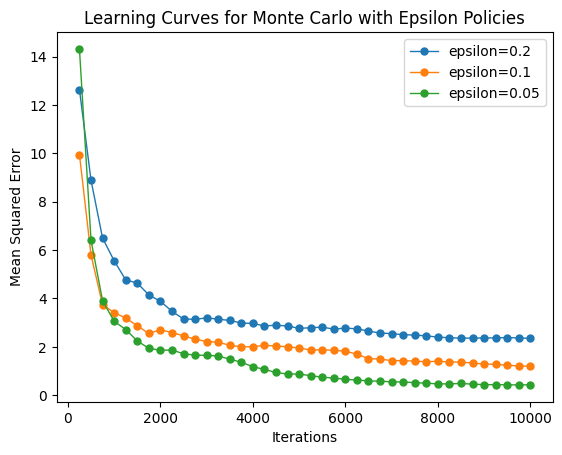

In [20]:
epsilons = [0.2, 0.1, 0.05]
results = {}

for epsilon in epsilons:
    q, policy, errors, v_hat = monte_carlo_with_epsilon_policies(epsilon)
    # print(errors)
    print_results(v_hat, q, policy, epsilon)
    results[f"epsilon={epsilon}"] = errors

plot_learning_curves(results)

Value Function (v_hat):
-1.8704  -1.9911  -2.8452  -3.8701  -2.8562
-1.9060  -1.9889  -2.5073  -1.3589  2.9650
-2.0801  0.0000  0.0000  0.0000  6.0537
-3.3900  -6.4607  0.0000  6.1315  8.8314
-6.9700  -5.1454  2.7886  8.4354  0.0000




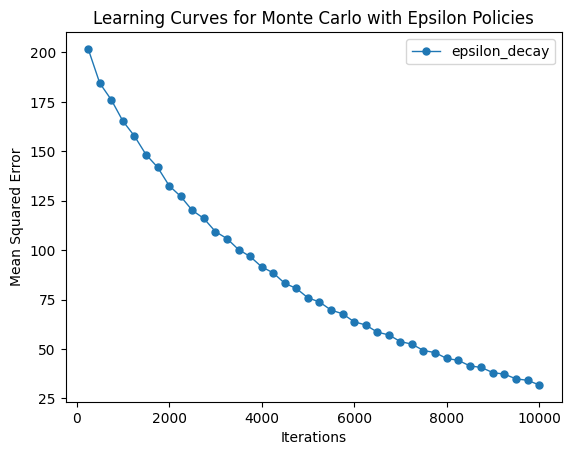

In [21]:
results = {}
q, policy, errors, v_hat = monte_carlo_with_epsilon_policies(1, decay=True)
print_results(v_hat, q, policy)
results["epsilon_decay"] = errors
plot_learning_curves(results)